# Transfer Learning

A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using TensorFlow.

## Install and import TensorFlow libraries

Let's start by ensuring that we have the latest version of the **TensorFlow** package installed and importing the Tensorflow libraries we're going to use.

In [11]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.11.1
Keras version: 2.11.0


## Prepare the base model

To use transfer learning, we need a base model from which we can use the trained feature extraction layers. The ***resnet*** model is an CNN-based image classifier that has been pre-trained using a huge dataset of 3-color channel images of 224x224 pixels. Let's create an instance of it with some pretrained weights, excluding its final (top) prediction layer.

In [12]:
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Prepare the image data

The pretrained model has many layers, starting with a convolutional layer that starts the feature extraction process from image data.

For feature extraction to work with our own images, we  need to ensure that the image data we use to train our prediction layer has the same number of features (pixel values) as the images originally used to train the feature extraction layers, so we need data loaders for color images that are 224x224 pixels in size.

Tensorflow includes functions for loading and transforming data. We'll use these to create a generator for training data, and a second generator for test data (which we'll use to validate the trained model). The loaders will transform the image data to match the format used to train the original resnet CNN model and normalize them.

Run the following cell to define the data generators and list the classes for our images.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/food'
pretrained_size = (224,224)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 283 images belonging to 3 classes.
Preparing validation dataset...
Found 120 images belonging to 3 classes.
class names:  ['Chicken', 'Potatoes', 'Rice']


## Create a prediction layer

We downloaded the complete *resnet* model excluding its final prediction layer, so need to combine these layers with a fully-connected (*dense*) layer that takes the flattened outputs from the feature extraction layers and generates a prediction for each of our image classes.

We also need to freeze the feature extraction layers to retain the trained weights. Then when we train the model using our images, only the final prediction layer will learn new weight and bias values - the pre-trained weights already learned for feature extraction will remain the same.

In [14]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create prediction layer for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Train the Model

With the layers of the CNN defined, we're ready to train it using our image data. The weights used in the feature extraction layers from the base resnet model will not be changed by training, only the final dense layer that maps the features to our shape classes will be trained.

In [15]:
# Train the model over 3 epochs
num_epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/50


c:\Users\elain\OneDrive\Desktop\image_classification\ipcv\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 [==============================] - 75s 7s/step - loss: 4.8589 - accuracy: 0.3518 - val_loss: 2.7321 - val_accuracy: 0.3917
Epoch 2/50
9/9 [==============================] - 61s 7s/step - loss: 1.5414 - accuracy: 0.5573 - val_loss: 2.0546 - val_accuracy: 0.4417
Epoch 3/50
9/9 [==============================] - 58s 7s/step - loss: 0.9209 - accuracy: 0.6630 - val_loss: 2.0787 - val_accuracy: 0.4250
Epoch 4/50
9/9 [==============================] - 63s 7s/step - loss: 0.9478 - accuracy: 0.6778 - val_loss: 2.2252 - val_accuracy: 0.4417
Epoch 5/50
9/9 [==============================] - 61s 7s/step - loss: 0.7797 - accuracy: 0.6917 - val_loss: 1.3062 - val_accuracy: 0.5250
Epoch 6/50
9/9 [==============================] - 62s 7s/step - loss: 0.6085 - accuracy: 0.7510 - val_loss: 1.3904 - val_accuracy: 0.5333
Epoch 7/50
9/9 [==============================] - 62s 7s/step - loss: 0.7534 - accuracy: 0.7194 - val_loss: 1.2404 - val_accuracy: 0.5667
Epoch 8/50
9/9 [=============================

## View the loss history

We tracked average training and validation loss for each epoch. We can plot these to verify that the loss reduced over the training process and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

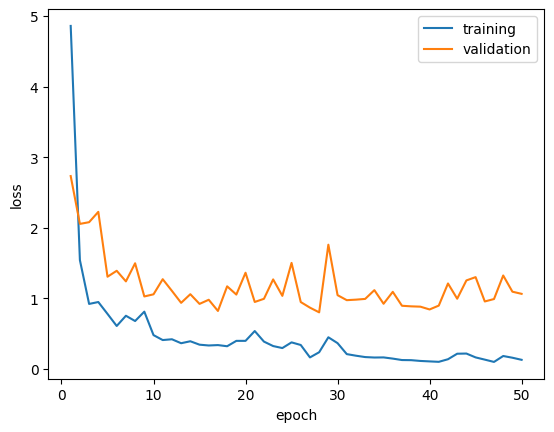

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...
1/1 [==============================] - 12s 12s/step


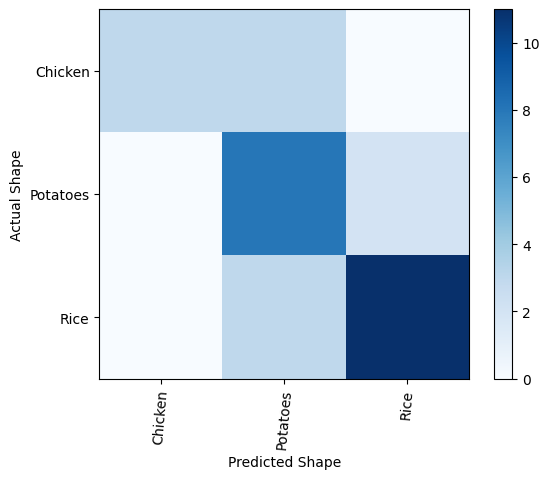

In [17]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

In [18]:
modelFileName = 'models/food.h5'
model.save(modelFileName)
del model
print ('model saved as', modelFileName)

model saved as models/food.h5


## Evaluate model performance

We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

In [19]:
import os
import numpy as np
import tensorflow
from  tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input



# 1. Load your trained Keras model

model = keras.models.load_model('models/food.h5')



# 2. Load and preprocess the images from the folder
image_folder = './inferencing'
image_files = os.listdir(image_folder)



# Set image size to match your model's input shape
img_width, img_height = 224, 224



# Preprocess images and store them in a list
preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)



# 3. Perform inference on the preprocessed images
predictions = [model.predict(img) for img in preprocessed_images]


classnames = os.listdir(os.path.join('data', 'food'))
classnames.sort()

# Use the classifier to predict the class
#class_idx = predict_image(model, img)
#print (classnames[class_idx])
# 4. (Optional) Save or display the results
# Here, we simply print the predictions for each image
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class:{classnames[index]}")

1/1 [==============================] - 0s 311ms/step
Prediction for Chicken_1.jpg: [[5.2838569e-25 1.0000000e+00 1.4387748e-16]] Class:Potatoes
Prediction for Chicken_2.jpg: [[7.7022093e-16 1.0000000e+00 7.6775586e-11]] Class:Potatoes
Prediction for Chicken_3.jpg: [[1.3299066e-11 1.0000000e+00 1.1953680e-10]] Class:Potatoes
Prediction for Chicken_4.jpg: [[6.2958859e-24 1.0000000e+00 7.6918036e-19]] Class:Potatoes
Prediction for Potato_1.jpg: [[2.1720836e-10 1.0000000e+00 6.8865633e-13]] Class:Potatoes
Prediction for Potato_2.jpg: [[3.6503646e-29 1.0000000e+00 2.6087527e-18]] Class:Potatoes
Prediction for Potato_3.jpg: [[2.5385148e-12 1.0000000e+00 1.8796509e-08]] Class:Potatoes
Prediction for Potato_4.jpg: [[1.7583629e-09 9.9999952e-01 5.1370512e-07]] Class:Potatoes
Prediction for Rice_1.jpg: [[8.5276394e-26 1.0000000e+00 4.5778339e-13]] Class:Potatoes
Prediction for Rice_2.jpg: [[1.0463146e-20 1.0000000e+00 2.8226208e-16]] Class:Potatoes
Prediction for Rice_3.jpg: [[3.1684854e-26 1.00

## Learn More

* [Tensorflow Documentation](https://www.tensorflow.org/tutorials/images/transfer_learning)